### get data

In [10]:
%cd /Users/lev/fractal-defi

/Users/lev/fractal-defi


In [11]:
from examples.ml_funding_rate_forecasting.utils.get_data import (
    get_list_top_n_tickers, 
    download_spot_future_fr_data
)
from examples.ml_funding_rate_forecasting.utils.process_data import (
    process_ticker
)
from examples.ml_funding_rate_forecasting.utils.create_features import (
    extract_time_series_features,
    extract_features,
    rsi,
    mfi,
    ema
)
from examples.ml_funding_rate_forecasting.utils.metrics import (
    smape
)

In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta

from catboost import CatBoostRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [13]:
current_time = datetime(
    year = 2025, 
    month = 4, 
    day = 16
)
years = 1
delta = timedelta(days=365 * years)
start_time = current_time - delta

In [23]:
list_top_n_tickers = get_list_top_n_tickers(10)

download_spot_future_fr_data(
    futures_spot_tickers=list_top_n_tickers, 
    start_timestamp=start_time,
    end_timstamp=current_time,
    interval='1h'
)

100%|██████████| 10/10 [01:48<00:00, 10.85s/it]


### process data

In [24]:
data = {}
for ticker in tqdm(list_top_n_tickers):
    df_tmp = process_ticker(ticker)
    data[ticker] = df_tmp

100%|██████████| 10/10 [00:00<00:00, 59.01it/s]


In [25]:
features_list = []
tickers = []

for ticker, df in data.items():

    if df.shape[0]:
        train_size = int(df.shape[0] * 0.8)
        df = df.iloc[1:train_size]
        df = df.iloc[7::8]

        if df.shape[0] <= 300:
            print(ticker)
            continue

        fr_series = df['fundingRate']
        feats = extract_time_series_features(fr_series)

        if feats:
            features_list.append(feats)
            tickers.append(ticker)
    else:
        print(ticker)

features_df = pd.DataFrame(features_list, index=tickers)

TRUMPUSDT
PENGUUSDT


In [26]:
features_df.head()

,std,mean_abs_change,acf_lag1,acf_lag2,acf_lag3,trend_slope,trend_r2,rolling_std_24,rolling_mean_24,sign_changes,spike_count_z3,skew,kurtosis,mean_reversion_strength
ETHUSDT,0.726729,0.299383,0.751267,0.677566,0.662993,0.000719,0.062586,0.370212,0.977511,0.065143,0.020571,1.996639,9.742366,-0.751267
BTCUSDT,0.831606,0.353806,0.700433,0.603016,0.590142,0.000823,0.062505,0.459847,0.925262,0.115429,0.014857,2.124612,15.644963,-0.700433
SOLUSDT,1.057794,0.543028,0.632255,0.569776,0.572462,0.000070,0.000281,0.668016,0.827856,0.219429,0.021714,0.439668,11.959250,-0.632255
XRPUSDT,0.828963,0.453611,0.577581,0.464757,0.380358,0.000579,0.031183,0.555962,0.918307,0.150857,0.020571,2.074216,14.054786,-0.577581
ETHUSDC,0.683286,0.273409,0.659234,0.587668,0.532508,0.000492,0.033064,0.370209,0.934814,0.081143,0.020571,1.368513,16.176271,-0.659234


### clusters

Two clustering options:
1. according to the features extracted from the funding rate
2. according to market indicators extracted from the asset price (relative, such as MFI, RSI, etc.)

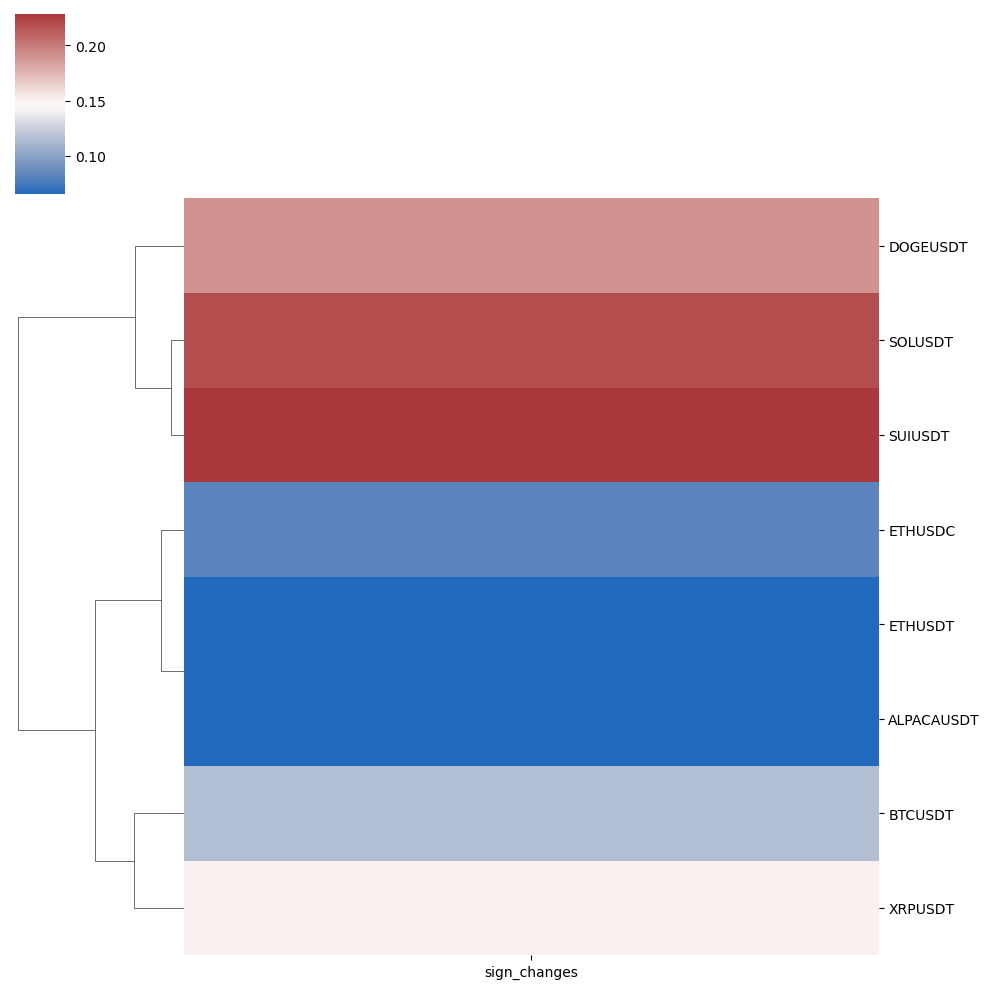

In [28]:
sns.clustermap(features_df['sign_changes'], cmap="vlag", col_cluster=False)
# plt.savefig('images/heatmap_sign_changes.png')

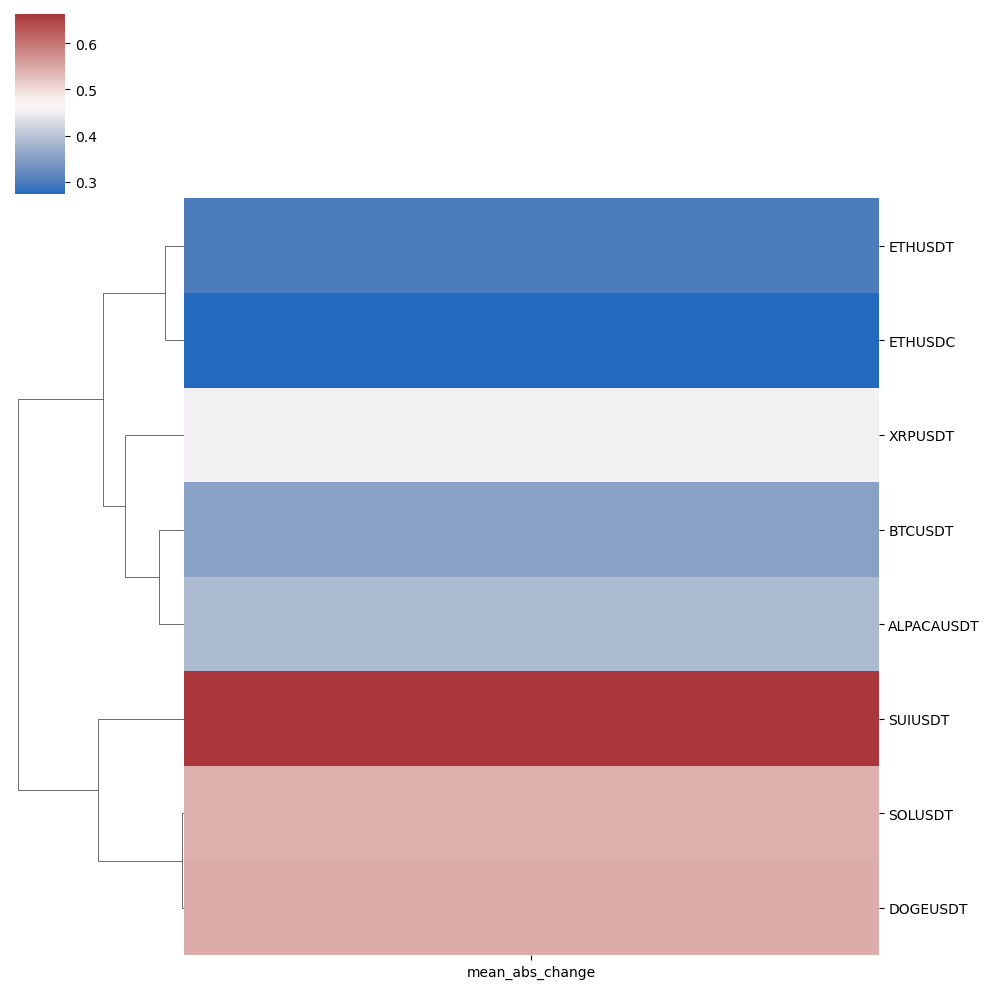

In [29]:
sns.clustermap(features_df['mean_abs_change'], cmap="vlag", col_cluster=False)
# plt.savefig('images/heatmap_mean_fr_change.png')

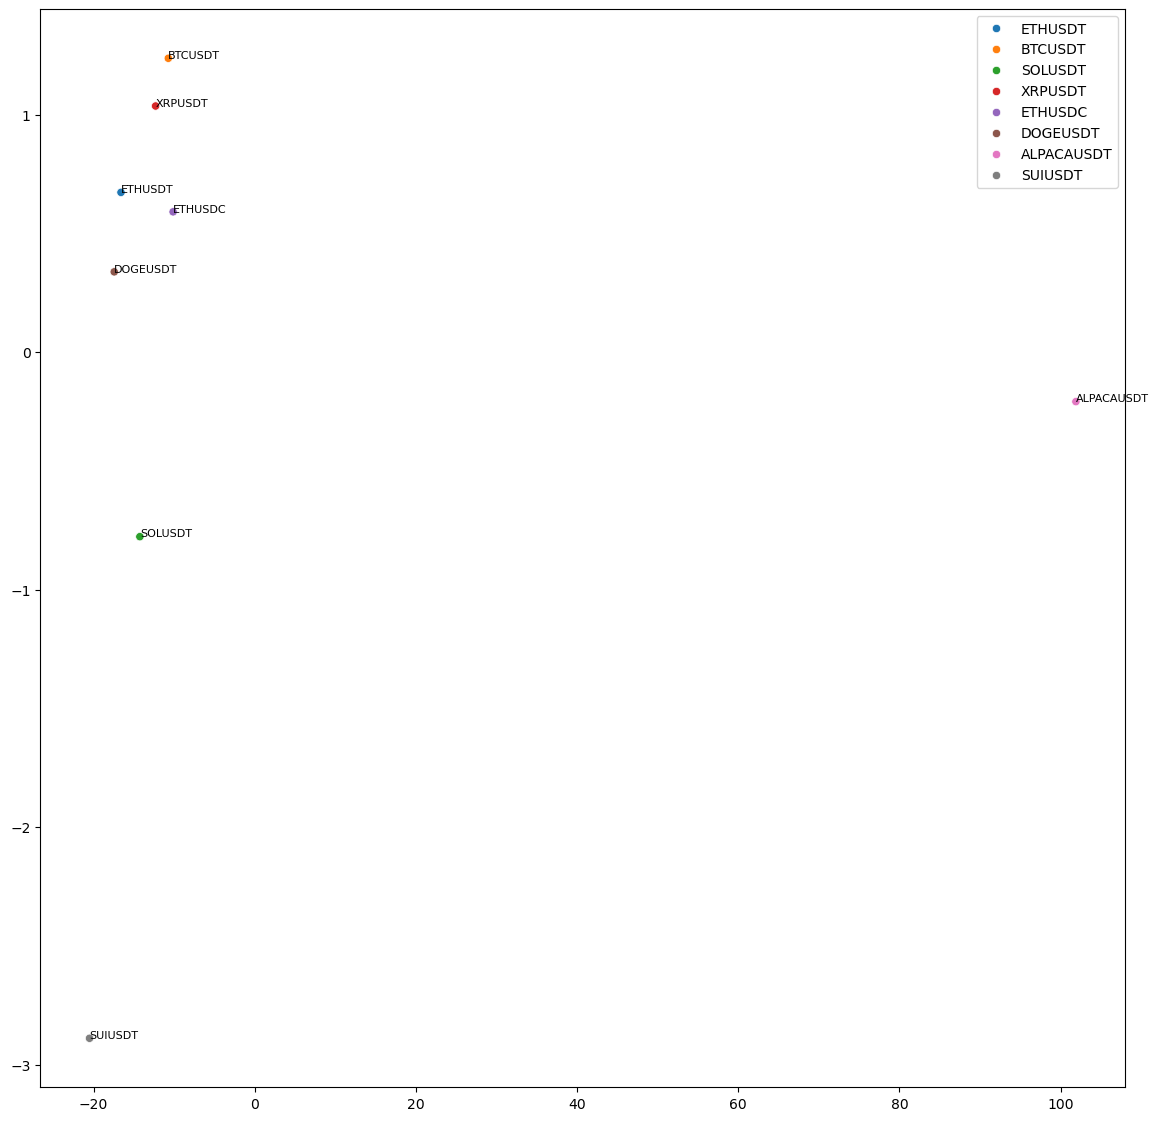

In [30]:
pca = PCA(n_components=2)
components = pca.fit_transform(features_df)

plt.figure(figsize=(14, 14))

sns.scatterplot(x=components[:,0], y=components[:,1], hue=features_df.index.to_list())
for i, ticker in enumerate(features_df.index):
    plt.text(components[i,0], components[i,1], ticker, fontsize=8)

# plt.savefig('images/clusters_PCA.png')

In [31]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

features_df['cluster'] = cluster_labels

In [34]:
embedding = TSNE(n_components=2, random_state=42, perplexity=2).fit_transform(features_scaled)

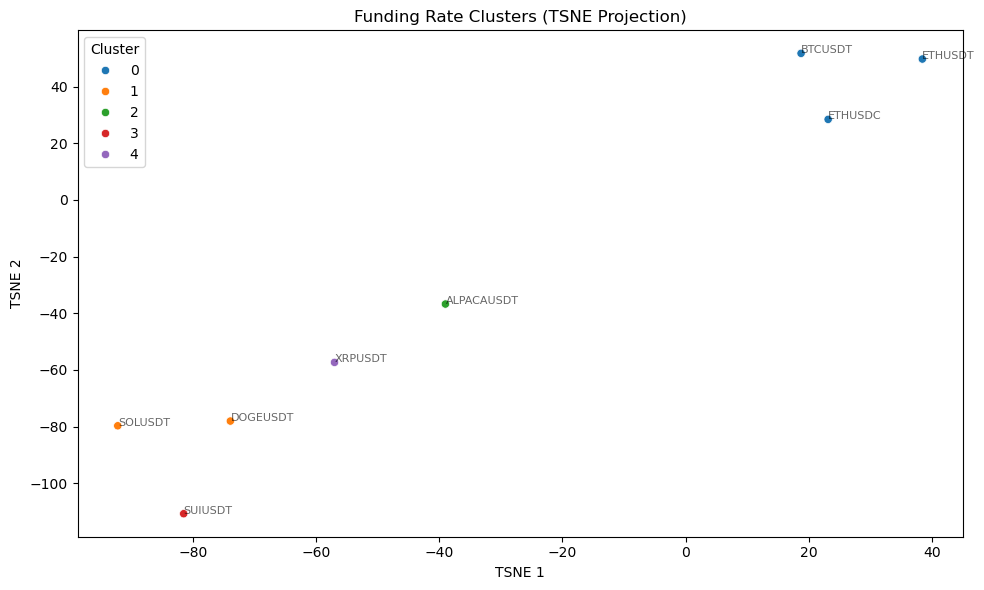

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette='tab10')
for i, ticker in enumerate(tickers):
    plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.6)
plt.title("Funding Rate Clusters (TSNE Projection)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Cluster", loc='best')
plt.tight_layout()
# plt.savefig('images/clusters_TSNE_KMeans.png')
plt.show()

In [36]:
def plot_clusters(embedding, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', legend='full')
    for i, ticker in enumerate(tickers):
        plt.text(embedding[i, 0], embedding[i, 1], ticker, fontsize=8, alpha=0.5)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()
    plt.show()

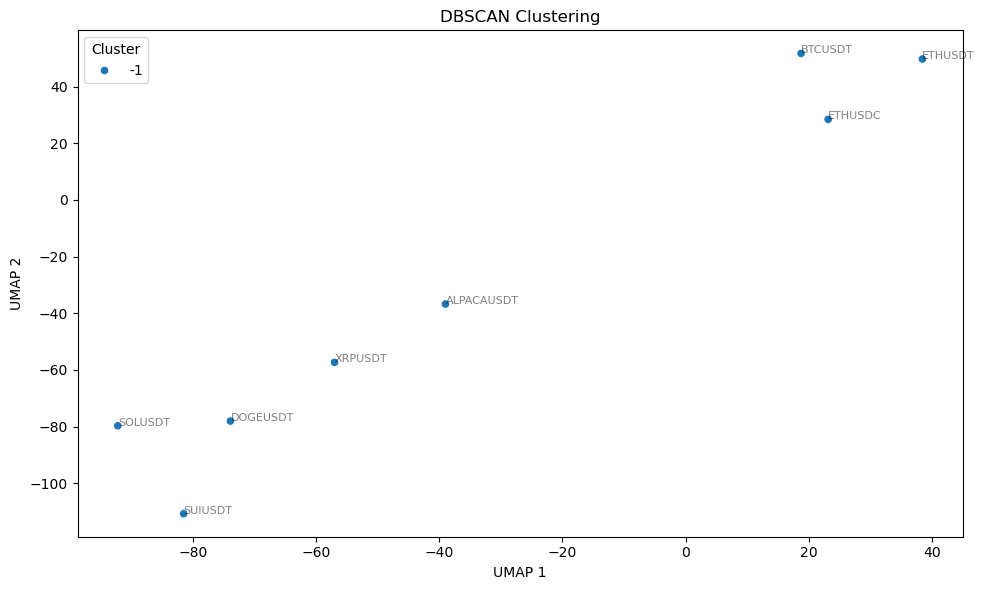

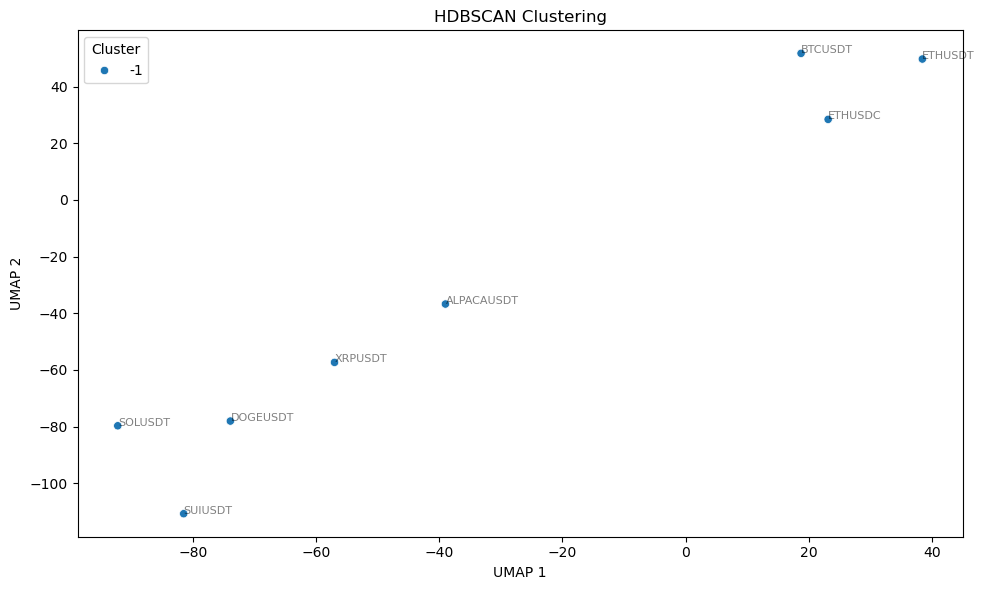

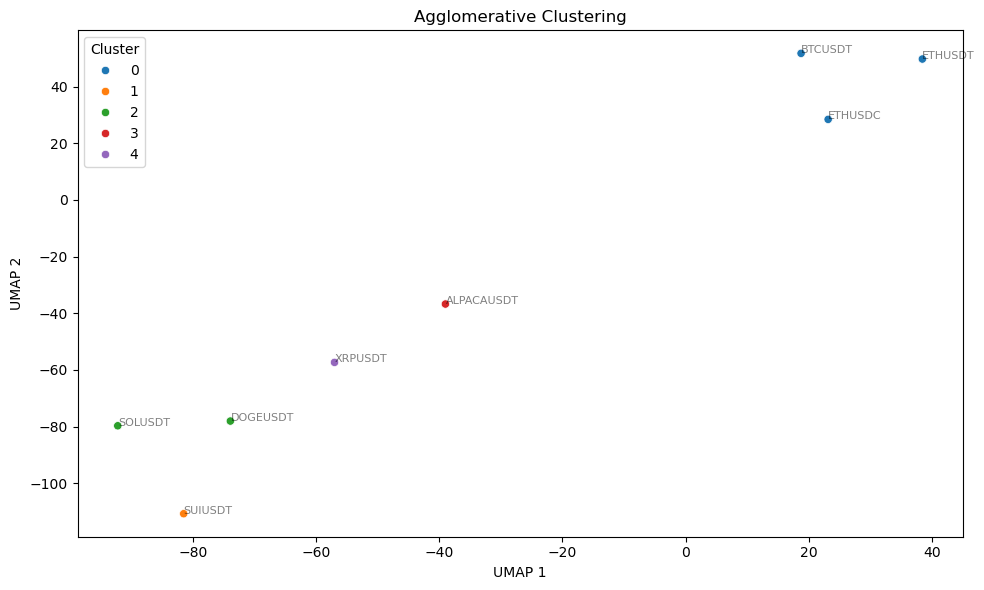

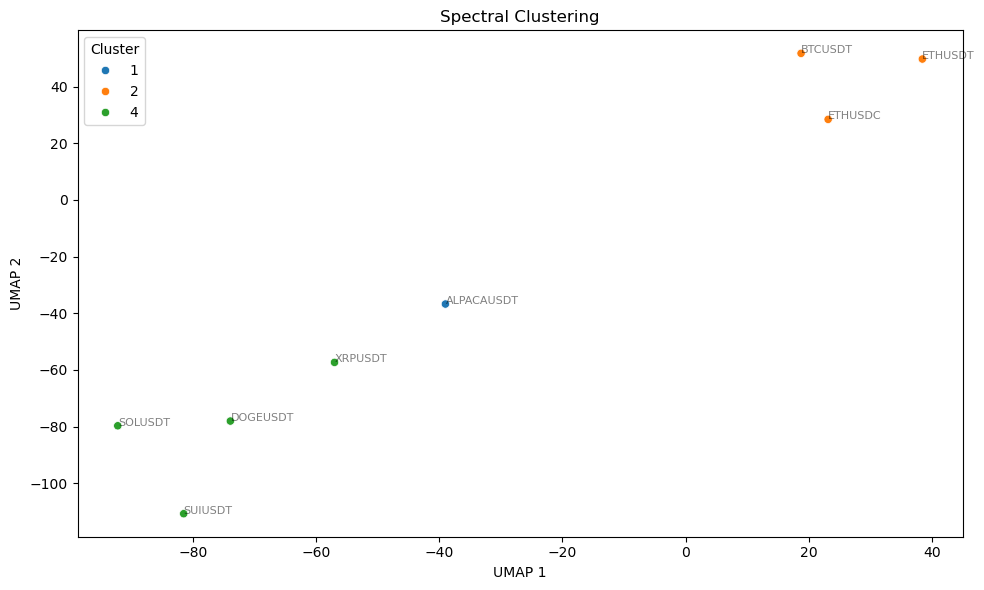

In [37]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=1.2, min_samples=3)
db_labels = dbscan.fit_predict(features_scaled)
plot_clusters(embedding, db_labels, "DBSCAN Clustering")

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=3)
hdb_labels = hdb.fit_predict(features_scaled)
plot_clusters(embedding, hdb_labels, "HDBSCAN Clustering")

# --- Agglomerative Clustering ---
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(features_scaled)
plot_clusters(embedding, agg_labels, "Agglomerative Clustering")

# --- Spectral Clustering ---
spectral = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=42)
spectral_labels = spectral.fit_predict(features_scaled)
plot_clusters(embedding, spectral_labels, "Spectral Clustering")

### research, modeling

In [38]:
df = data['ETHUSDT'].copy()

In [39]:
df['fundingRate'] = df['fundingRate'].shift(-1)
df = df.iloc[:-1]

df['hour_index'] = df['open_time'].str[11:13].astype(int) % 8 + 1

df['basis'] = df['close_futr'] - df['close_spot']
df['basis_relative'] = df['basis'] / df['close_futr']
df['target'] = df['basis'].shift(2)
df = df.iloc[2:]

df.reset_index(drop=True, inplace=True)

In [40]:
features_df = pd.DataFrame([extract_features(df, i) for i in range(len(df))])

In [41]:
df['volume_ratio'] = df['volume_futr'] / df['volume_spot']
df = pd.concat([df, features_df], axis=1)

In [42]:
df['sma_fr_7'] = df.fundingRate.rolling(8 * 7).mean().shift(1)
df['sma_fr_3'] = df.fundingRate.rolling(8 * 3).mean().shift(1)

df['sma_basis_14'] = df['basis'].rolling(14).mean().shift(1)
df['sma_basis_7'] = df['basis'].rolling(7).mean().shift(1)
df['sma_basis_3'] = df['basis'].rolling(3).mean().shift(1)

windows = [7, 14, 28]
for window in windows:
    df[f'EMA_{window}'] = ema(df, window)
    df[f'RSI_{window}'] = rsi(df, window)
    df[f'MFI_{window}'] = mfi(df, window)

In [43]:
# del data leak
df = df[df['hour_index'] != 8]

In [44]:
cols = [
    'log_return', 'volatility', 'avg_volume_futr', 'avg_volume_spot',
    'basis_mean', 'basis_std', 'hour_index', 'volume_ratio',
    'sma_fr_3', 'sma_fr_7',
    'sma_basis_3', 'sma_basis_7', 'sma_basis_14',
    'RSI_7', 'MFI_7', 'EMA_7', 
    'RSI_14', 'MFI_14', 'EMA_14',
    'RSI_28', 'MFI_28', 'EMA_28',
]
train_size = int(df.shape[0] * 0.8)
x = df.iloc[:train_size][cols]
y = df.iloc[:train_size]['target']

test = df.iloc[train_size:]
x_test = df.iloc[train_size:][cols]
y_test = df.iloc[train_size:]['target']

In [45]:
kwargs = {'iterations': 200, 'depth': 4, 'verbose': False}
model = CatBoostRegressor(**kwargs)
model.fit(x, y)

In [46]:
feats = pd.DataFrame()
feats['feature'] = model.feature_names_
feats['importance'] = model.feature_importances_
feats.sort_values(by='importance', ascending=False).head(7)

,feature,importance
11,sma_basis_7,57.100434
10,sma_basis_3,24.749127
12,sma_basis_14,12.197333
18,EMA_14,3.007708
9,sma_fr_7,0.549275
19,RSI_28,0.326684
4,basis_mean,0.282556


In [59]:
# CatBoost results
preds_train = model.predict(x)
smape(y, preds_train)

0.15784188224191936

In [48]:
preds = model.predict(x_test)
test['preds'] = preds

smape(test['target'], test['preds'])


0.12026311833669263

In [49]:
train = df.iloc[:train_size]
train['preds'] = model.predict(x)

train['bin_preds'] = pd.qcut(train['preds'], q=20)
train.groupby('bin_preds')['fundingRate'].agg(['count', 'mean'])

,count,mean
bin_preds,,
"(-2.8249999999999997, -1.628]",307,0.000048
"(-1.628, -1.545]",306,0.000053
"(-1.545, -1.44]",306,0.000057
"(-1.44, -1.389]",306,0.000058
"(-1.389, -1.325]",306,0.000057
"(-1.325, -1.285]",306,0.000049
"(-1.285, -1.251]",307,0.000053
"(-1.251, -1.196]",306,0.000060
"(-1.196, -1.154]",306,0.000054


In [50]:
test['bin_preds'] = pd.qcut(test['preds'], q=10)
test.groupby('bin_preds')['fundingRate'].agg(['count', 'mean'])

,count,mean
bin_preds,,
"(-2.51, -1.387]",154,-0.000008
"(-1.387, -1.271]",153,0.000027
"(-1.271, -1.167]",153,0.000029
"(-1.167, -1.078]",153,0.000027
"(-1.078, -0.987]",153,0.000032
"(-0.987, -0.932]",153,0.000024
"(-0.932, -0.873]",153,0.000025
"(-0.873, -0.822]",153,0.000024
"(-0.822, -0.725]",153,0.000017


In [51]:
train['bin_preds'] = pd.qcut(train['preds'], q=50)
mapping = train.groupby('bin_preds')['fundingRate'].agg(['mean'])
mapping = mapping.to_dict()

def process_prediction(x, mapping):
    prediction = x
    for key, value in mapping['mean'].items():
        left = key.left
        right = key.right
        if prediction > left and prediction < right:
            return value
    return 0.0001

train['preds_fr'] = train['preds'].map(lambda x: process_prediction(x, mapping))
test['preds_fr'] = test['preds'].map(lambda x: process_prediction(x, mapping))

In [ ]:
# hour results on train data for price diff and fr
for i in range(1, 8):
    smape_basis = smape(train[train['hour_index'] == i]['target'], train[train['hour_index'] == i]['preds'])
    smape_fr = smape(train[train['hour_index'] == i]['fundingRate'], train[train['hour_index'] == i]['preds_fr'])
    print(i, smape_basis, smape_fr)

1 0.14542237315958456 0.4643104093584603
2 0.160050046905369 0.4551336866159632
3 0.15510389415039416 0.4390774636765799
4 0.1594450304002562 0.4345851125554674
5 0.1593838937329969 0.42987529245382844
6 0.16663078765609232 0.4296968244995525
7 0.15885967330550063 0.4291699010690266


In [ ]:
# hour results on test data for price diff and fr
for i in range(1, 8):
    smape_basis = smape(test[test['hour_index'] == i]['target'], test[test['hour_index'] == i]['preds'])
    smape_fr = smape(test[test['hour_index'] == i]['fundingRate'], test[test['hour_index'] == i]['preds_fr'])
    print(i, smape_basis, smape_fr)

1 0.11126622798530474 1.06322125933456
2 0.11785766870226927 1.0658978109574033
3 0.12101112018896662 1.0772447979562056
4 0.13253416362545203 1.0714623240578942
5 0.1163576378594303 1.0759677233830396
6 0.1184092305987197 1.0790647157120223
7 0.12436469770560345 1.0722698610053771


In [ ]:
# simple const baseline
smape(test.fundingRate, [0.0001] * len(test))

1.1978145717789466

In [ ]:
# rolling mean baseline
smape(test.fundingRate, test.fundingRate.rolling(8 * 3).mean().shift(7))

1.1689859011305872

In [ ]:
# CatBoost funding rate results
smape(test.fundingRate, test.preds_fr)

1.072167048679954

In [ ]:
# Correlation between funidng rate on price diff on train data
np.corrcoef(train.fundingRate, train.basis)

array([[1.        , 0.68832924],
       [0.68832924, 1.        ]])

In [ ]:
# Correlation between funidng rate on price diff on test data
np.corrcoef(test.fundingRate, test.basis)

array([[1.        , 0.18272521],
       [0.18272521, 1.        ]])